# Language Model Exercises
In these exercises you will extend and develop language models. We will use the code from the notes, but within a python package [`lm`](http://localhost:8888/edit/statnlpbook/lm.py).

## <font color='green'>Setup 1</font>: Load Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sys, os
_snlp_book_dir = ".."
sys.path.append(_snlp_book_dir) 
from statnlpbook.lm import *
from statnlpbook.ohhla import *
# %cd .. 
import sys
sys.path.append("..")
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)

<!---
Latex Macros
-->
$$
\newcommand{\prob}{p}
\newcommand{\vocab}{V}
\newcommand{\params}{\boldsymbol{\theta}}
\newcommand{\param}{\theta}
\DeclareMathOperator{\perplexity}{PP}
\DeclareMathOperator{\argmax}{argmax}
\newcommand{\train}{\mathcal{D}}
\newcommand{\counts}[2]{\#_{#1}(#2) }
$$

## <font color='green'>Setup 2</font>: Load Data

In [2]:
docs = load_all_songs("../data/ohhla/train/www.ohhla.com/anonymous/j_live/")
assert len(docs) == 50, "Your ohhla corpus is corrupted, please download it again!"
trainDocs, testDocs = docs[:len(docs)//2], docs[len(docs)//2:] 
train = words(trainDocs)
test = words(testDocs)

## <font color='blue'>Task 1</font>: Optimal Pseudo Count 

Plot the perplexity for laplace smoothing on the given data as a function of alpha in the interval [0.001, 0.1] in steps by 0.001. Is it fair to assume that this is a convex function? Write a method that finds the optimal pseudo count `alpha` number for [laplace smoothing](https://github.com/uclmr/stat-nlp-book/blob/python/statnlpbook/lm.py#L180) for the given data up to some predefined numerical precision `epsilon` under the assumption that the perplexity is a convex function of alpha. How often did you have to call `perplexity` to find the optimum?

Tips:
<font color='white'>
You don't need 1st or 2nd order derivatives in this case, only the gradient descent direction. Think about recursively slicing up the problem.
</font>

1.0 0.0
0.5 0.0
0.25 0.0


0.125 0.0
0.0625 0.0
0.03125 0.0


0.03125 0.015625
0.0234375 0.015625
0.0234375 0.01953125


0.0234375 0.021484375
0.0234375 0.0224609375
0.02294921875 0.0224609375


0.02294921875 0.022705078125
0.02294921875 0.0228271484375
0.02294921875 0.02288818359375


0.02294921875 0.022918701171875
0.0229339599609375 0.022918701171875
0.0229339599609375 0.02292633056640625


0.0229339599609375 0.022930145263671875
0.022932052612304688 0.022930145263671875
0.022932052612304688 0.02293109893798828


(0.022932052612304688, 62.533861271953555)

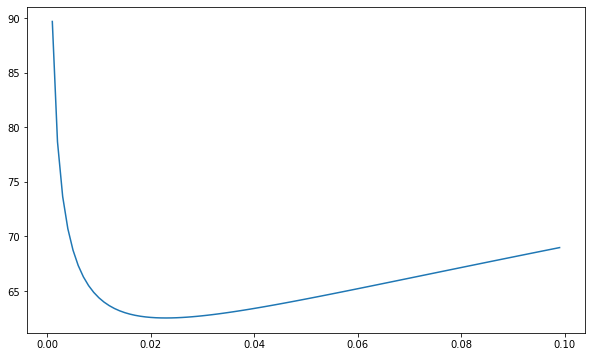

In [3]:
oov_train = inject_OOVs(train)
oov_vocab = set(oov_train)
oov_test = replace_OOVs(oov_vocab, test)
bigram = NGramLM(oov_train,2)

interval = [x/1000.0 for x in range(1, 100, 1)]
perplexit_at_1 = perplexity(LaplaceLM(bigram, alpha=1.0), oov_test)

def plot_perplexities(interval):
    """Plots the perplexity of LaplaceLM for every alpha in interval."""
    perplexities = [perplexity(LaplaceLM(bigram, alpha), oov_test) for alpha in interval]  # todo
    plt.plot(interval, perplexities)
    
def find_optimal(low, high, epsilon=1e-6):
    """Returns the optimal pseudo count alpha within the interval [low, high] and the perplexity."""
    print(high, low)
    if high - low < epsilon:
        return high, perplexity(LaplaceLM(bigram, high), oov_test)
    else:
        mid = (high+low) / 2.0
        left = perplexity(LaplaceLM(bigram, mid-epsilon), oov_test)
        right = perplexity(LaplaceLM(bigram, mid+epsilon), oov_test)
        if left < right:
            return find_optimal(low, mid, epsilon)
        else:
            return find_optimal(mid, high, epsilon)

plot_perplexities(interval)        
find_optimal(0.0, 1.0)

## <font color='blue'>Task 2</font>: Sanity Check LM
Implement a method that tests whether a language model provides a valid probability distribution.

In [4]:
def sanity_check(lm, *history):
    """Throws an AssertionError if lm does not define a valid probability distribution for all words 
    in the vocabulary."""  
    probability_mass = sum([lm.probability(word, *history) for word in lm.vocab])
    assert abs(probability_mass - 1.0) < 1e-6, probability_mass

unigram = NGramLM(oov_train,1)
stupid = StupidBackoff(bigram, unigram, 0.1)
print(sum([stupid.probability(word, 'the') for word in stupid.vocab]))
assert OOV in stupid.vocab
sanity_check(stupid, 'the')

1.0661659877800445


AssertionError: 1.0661659877800445

## <font color='blue'>Task 3</font>: Subtract Count LM
Develop and implement a language model that subtracts a count $d\in[0,1]$ from each non-zero count in the training set. Let's first formalise this:


\begin{align}
\#_{w=0}(h_n) &= \sum_{w \in V} \mathbf{1}[\counts{\train}{h_n,w} = 0]\\
\#_{w>0}(h_n) &= \sum_{w \in V} \mathbf{1}[\counts{\train}{h_n,w} > 0]\\
\prob(w|h_n) &= 
\begin{cases}
\frac{\counts{\train}{h_n,w} - d}{\counts{\train}{h_n}}  & \mbox{if }\counts{\train}{h_n,w} > 0 \\\\
\frac{d*\#_{w>0}(h_n)/\#_{w=0}(h_n)}{\counts{\train}{h_n}} & \mbox{otherwise}
\end{cases}
\end{align}

In [11]:
class SubtractCount(CountLM):        
    def __init__(self, base_lm, d):
        super().__init__(base_lm.vocab, base_lm.order)
        self.base_lm = base_lm
        self.d = d            
        self._counts = base_lm._counts  # not good style since it is a protected member
        self.vocab = base_lm.vocab

    def counts(self, word_and_history):
        # todo: this can be chached and does not have to be called at every call of counts        
        history = word_and_history[1:]        
        num_non_zero_histories = len([x for x in self.vocab if self._counts[(x, ) + history] > 0])
        num_zero_histories = len(self.vocab) - num_non_zero_histories        
        if num_zero_histories == 0:
            return self._counts[word_and_history]
        else:        
            if self._counts[word_and_history] > 0:
                return self._counts[word_and_history] - self.d
            else:            
                return self.d * num_non_zero_histories / num_zero_histories

    def norm(self, history):
        return self.base_lm.norm(history)    
    
subtract_lm = SubtractCount(unigram, 0.1)
oov_prob = subtract_lm.probability(OOV, 'the')
rest_prob = sum([subtract_lm.probability(word, 'the') for word in subtract_lm.vocab])
print(oov_prob + rest_prob)
sanity_check(subtract_lm, 'the')
perplexity(subtract_lm, oov_test)

1.1742331911436041


91.4414922652717

## <font color='blue'>Task 4</font>: Normalisation of Stupid LM
Develop and implement a version of the [stupid language model](https://github.com/uclmr/stat-nlp-book/blob/python/statnlpbook/lm.py#L205) that provides probabilities summing up to 1.

In [9]:
class StupidBackoffNormalized(LanguageModel):
    def __init__(self, main, backoff, alpha):
        super().__init__(main.vocab, main.order)
        self.main = main
        self.backoff = backoff
        self.alpha = alpha               

    def probability(self, word, *history):
        main_counts = self.main.counts((word,)+tuple(history))
        main_norm = self.main.norm(history)        
        backoff_order_diff = self.main.order - self.backoff.order
        backoff_counts = self.backoff.counts((word,)+tuple(history[:-backoff_order_diff]))
        backoff_norm = self.backoff.norm(history[:-backoff_order_diff])        
        counts = main_counts + self.alpha * backoff_counts
        norm = main_norm + self.alpha * backoff_norm
        return counts / norm
        
less_stupid = StupidBackoffNormalized(bigram, unigram, 0.1)
print(sum([less_stupid.probability(word, 'the') for word in less_stupid.vocab]))
sanity_check(less_stupid, 'the')
perplexity(less_stupid, oov_test)

1.000000000000002


60.032236179798886